# _Random Forest Regressor_ y correr 5 kilómetros
En el décimo proyecto vamos a predecir el tiempo estimado que un corredor tardará en completar una carrera de 5 kilómetros, usando características observables del corredor, como su experiencia y ritmo en distancias anteriores. El modelo que usaremos se llama _Random Forest Regressor_, un método muy popular y potente en _machine learning_ para problemas de predicción con variables continuas (como un tiempo en minutos). Es un modelo robusto y diseñado para manejar datos con relaciones no lineales y complejas entre variables. En este caso, la regresión lineal del cuaderno anterior no sería lo suficientemente precisa. _Let's go, sir!_

## Importar librerías necesarias
Como siempre, necesitamos importar algunas librerías que nos ayudarán a manipular datos, entrenar modelos, evaluar resultados y crear gráficos. _You know the drill._ Ya estamos familiarizados con todas ellas, excepto `RandomForestRegressor`, nuestro bosque aleatorio de regresión. Ya te explicaré más adelante por qué se llama así.

In [1]:
# Importación de librerías necesarias.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Generación del dataset simulado
No tenemos datos de carreras reales, así que vamos a simular un conjunto con 1000 corredores. Cada corredor tendrá valores para:

- Su mejor tiempo en una carrera de 10K (en minutos)

- Su edad (años)

- Número de entrenamientos por semana

- Kilómetros promedio corridos por semana

- Años de experiencia corriendo.

Solo el 30% tendrán su tiempo real en 5K registrado, que será nuestra variable objetivo (lo que queremos predecir).

In [2]:
np.random.seed(42)  # Para que el proceso sea reproducible

data = pd.DataFrame()

data['mejor_10k'] = np.random.normal(45, 5, 1000)
data['edad'] = np.random.normal(35, 10, 1000)
data['entrenamientos'] = np.random.randint(1, 8, 1000)
data['kms_semana'] = np.random.normal(20, 10, 1000)
data['experiencia'] = np.random.normal(5, 3, 1000)

data['tiempo_5k'] = np.nan

mask = np.random.choice([True, False], 1000, p=[0.3, 0.7])
data.loc[mask, 'tiempo_5k'] = (
    0.6 * data.loc[mask, 'mejor_10k']
    - 0.1 * data.loc[mask, 'entrenamientos']
    - 0.05 * data.loc[mask, 'kms_semana']
    - 0.1 * data.loc[mask, 'experiencia']
    + 0.02 * data.loc[mask, 'edad']
    + np.random.normal(0, 1, mask.sum())
)


Usamos un poco de ruido aleatorio para simular variabilidad natural.

## Preparar los datos para el modelo
Vamos a tomar solo los corredores que tengan tiempo registrado en 5K para entrenar nuestro modelo. Además, porque las variables tienen rangos muy diferentes, las escalamos para que el modelo las analice en igualdad de condiciones. ¿Recuerdas a nuestro escalador `StandardScaler`? 

In [3]:
df_labeled = data.dropna(subset=['tiempo_5k']).copy()

X = df_labeled.drop(columns=['tiempo_5k'])
y = df_labeled['tiempo_5k']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## ¿Entonces qué es el modelo Random Forest?
Random Forest es un modelo de machine learning que funciona como un conjunto de árboles de decisión individuales. Cada árbol hace sus propias predicciones a partir de diferentes muestras aleatorias de los datos (esto se llama _bootstrapping_). Después, el modelo junta (por promedio si es regresión, o por voto si es clasificación) los resultados de todos los árboles para obtener una única predicción final. En este caso se promedia, porque nuestro modelo es de regresión.

La principal ventaja es que, al combinar muchos árboles, el resultado suele ser mucho más estable, preciso y robusto frente a datos ruidosos o relaciones complejas. _Random Forest_ no supone que los datos tengan que formar una línea recta ni una relación sencilla.Por eso, es especialmente útil cuando la relación entre las variables no es lineal o directa, y aporta ventajas sobre modelos más simples como la regresión lineal que usamos anteriormente.

Así que entrenemos al modelo con nuestros datos:

In [4]:
# Cien árboles con una semilla establecida.
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Evaluar el modelo
Después de entrenar, usamos el modelo para predecir los tiempos de los corredores en el conjunto de prueba y calculamos qué tan bien predijo respecto a los tiempos reales.

In [5]:
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Error cuadrático medio (MSE): {mse:.3f}')
print(f'Coeficiente de determinación (R^2): {r2:.3f}')

Error cuadrático medio (MSE): 1.647
Coeficiente de determinación (R^2): 0.846


El MSE nos dice qué tan alejadas están las predicciones en promedio y el R² indica qué tan bien el modelo explica la variabilidad real (1 es perfecto, 0 significa que no explica nada). Con base en esto podemos deducir lo siguiente:

- Error cuadrático medio (_MSE_): un valor de 1.647 significa que, en media, las predicciones están aproximadamente a 1.65 minutos del valor real del tiempo en la carrera. Mientras más cercano a cero sea este número, mejor.

- Coeficiente de determinación (R²): un R² de 0.846 quiere decir que el modelo explica el 84.6% de toda la variación de los tiempos reales. Un 1 sería perfecto (las predicciones son exactas) y un 0 significa que el modelo no explica nada.

Nuestro modelo predice bastante bien los tiempos.

## Visualización de resultados
Para entender mejor, comparemos en un gráfico los tiempos predichos contra los reales. Idealmente, los puntos deberían ubicarse cerca de la línea diagonal roja que indica predicción perfecta.

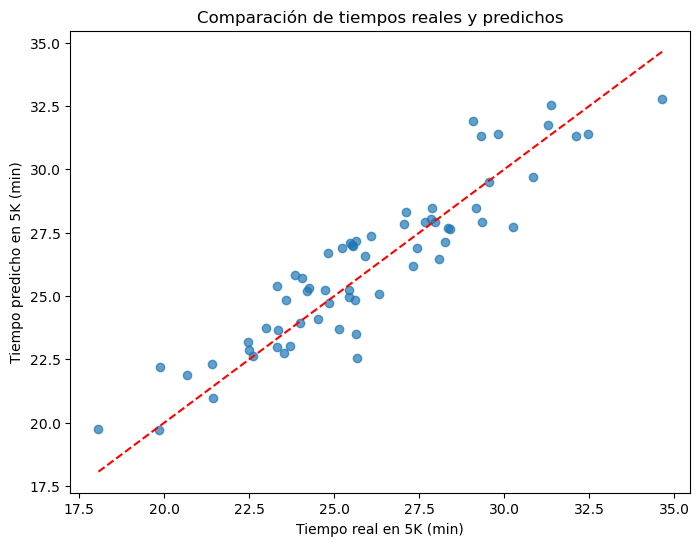

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Tiempo real en 5K (min)')
plt.ylabel('Tiempo predicho en 5K (min)')
plt.title('Comparación de tiempos reales y predichos')
plt.show()


## Conclusión
La evaluación del modelo _Random Forest_ nos muestra que el error promedio entre los tiempos predichos y los reales es bajo, y que el modelo logra predecir bastante bien los tiempos en 5K. Al observar la gráfica, vemos que la mayoría de los puntos están cerca de la línea roja, lo que significa que las predicciones suelen estar cerca de los valores reales. _Random Forest_ es una excelente elección cuando hay varios factores que afectan el resultado y la relación entre las variables no es simple ni lineal.

Así que ya lo sabes, cuando influyan muchos factores diferentes y la relación entre ellos no sea tan fácil de ver a simple vista, podrías usar un modelo de regresión como éste en vez de la regresión lineal.